# Лабораторная работа 5

## EDA с использованием seaborn

Тематика: подержанные автомобили в Великобритании.

Источник: [Used Cars Prices in UK](https://www.kaggle.com/datasets/muhammadawaistayyab/used-cars-prices-in-uk/data) (Kaggle, CSV)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

c:\Users\Platon\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Общая характеристика данных

In [3]:
path = kagglehub.dataset_download("muhammadawaistayyab/used-cars-prices-in-uk")
df = pd.read_csv(os.path.join(path, "used_cars_UK.csv"))
df.head()

,Unnamed: 0,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history
0,0,SKODA Fabia,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN
1,1,Vauxhall Corsa,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,2,Hyundai i30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN
3,3,MINI Hatch,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,4,Vauxhall Corsa,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN


In [4]:
print(f"Строк: {df.shape[0]}, столбцов: {df.shape[1]}")
print()
print("Типы:")
print(df.dtypes)
print()
num_cols = list(df.select_dtypes(include='number').columns)
cat_cols = list(df.select_dtypes(include='object').columns)
print(f"Числовые: {num_cols}")
print(f"Категориальные: {cat_cols}")

Строк: 3685, столбцов: 14

Типы:
Unnamed: 0             int64
title                 object
Price                  int64
Mileage(miles)         int64
Registration_Year      int64
Previous Owners      float64
Fuel type             object
Body type             object
Engine                object
Gearbox               object
Doors                float64
Seats                float64
Emission Class        object
Service history       object
dtype: object

Числовые: ['Unnamed: 0', 'Price', 'Mileage(miles)', 'Registration_Year', 'Previous Owners', 'Doors', 'Seats']
Категориальные: ['title', 'Fuel type', 'Body type', 'Engine', 'Gearbox', 'Emission Class', 'Service history']


Ключевые признаки:

- `Price` - цена (целевая переменная)
- `Mileage(miles)` - пробег
- `Registration_Year` - год регистрации
- `Previous Owners` - кол-во предыдущих владельцев
- `title` - название модели (категориальный, >=20 уникальных значений)
- `Fuel type`, `Body type`, `Gearbox`, `Engine`, `Emission Class`, `Service history` - прочие категориальные

In [5]:
print(f"Уникальных моделей (title): {df['title'].nunique()}")
df['title'].value_counts().head(20)

Уникальных моделей (title): 469


title
Vauxhall Corsa           223
Ford Focus               162
Vauxhall Astra           155
Ford Fiesta              128
BMW 3 Series             109
Renault Clio             105
Volkswagen Polo          101
Toyota Yaris              81
MINI Hatch                78
Mercedes-Benz C Class     58
Volkswagen Golf           56
Peugeot 308               50
Honda Civic               49
Nissan Qashqai            48
BMW 1 Series              47
Peugeot 207               47
Toyota Aygo               47
Vauxhall Insignia         45
SEAT Ibiza                45
Audi A3                   43
Name: count, dtype: int64

Признак `title` содержит названия моделей автомобилей. Уникальных значений значительно больше 20, что делает его подходящим категориальным признаком с большим числом категорий.

## 2. Анализ пропусков

In [7]:
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Пропуски': missing, '%': missing_pct})
missing_df[missing_df['Пропуски'] > 0].sort_values('%', ascending=False)

,Пропуски,%
Service history,3145,85.35
Previous Owners,1409,38.24
Emission Class,87,2.36
Engine,45,1.22
Seats,35,0.95
Doors,25,0.68


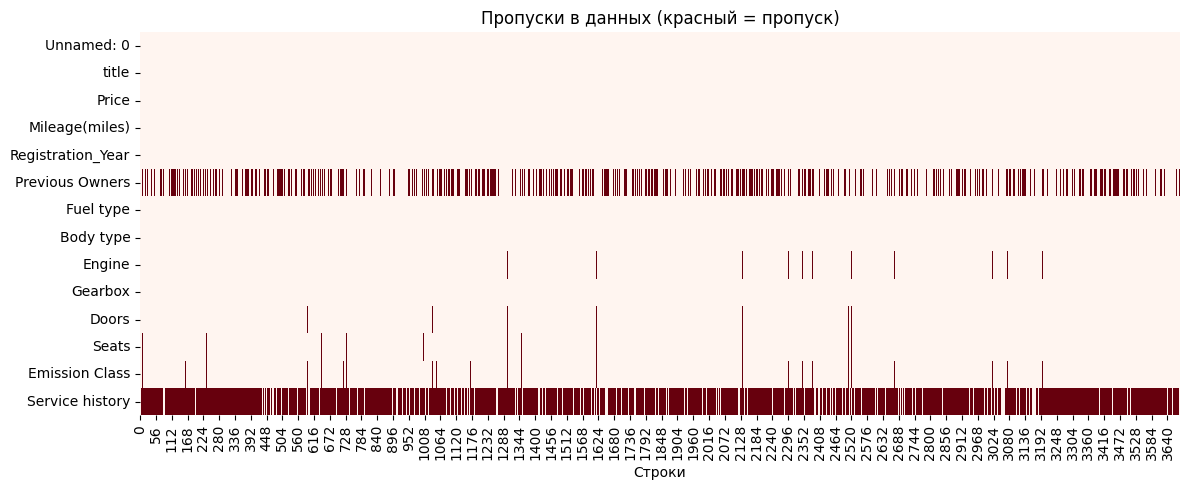

In [8]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(df.isnull().T, cbar=False, yticklabels=True, cmap='Reds', ax=ax)
ax.set_title('Пропуски в данных (красный = пропуск)')
ax.set_xlabel('Строки')
plt.tight_layout()
plt.show()

Больше всего пропусков в `Service history` (>60%). `Previous Owners` - около 20%. Остальные признаки имеют немного пропусков.

### Обработка пропусков

- `Service history` (>60%) - заполняем `'Unknown'`
- `Previous Owners` (около 20%) - заполняем медианой (распределение смещенное)
- `Doors`, `Seats` - заполняем медианой
- `Emission Class` - заполняем модой

In [9]:
df['Service history'] = df['Service history'].fillna('Unknown')
df['Previous Owners'] = df['Previous Owners'].fillna(df['Previous Owners'].median())
df['Doors'] = df['Doors'].fillna(df['Doors'].median())
df['Seats'] = df['Seats'].fillna(df['Seats'].median())
df['Emission Class'] = df['Emission Class'].fillna(df['Emission Class'].mode()[0])

# auxiliary columns
df['Engine_L'] = df['Engine'].str.replace('L', '').astype(float)
df['Emission_Num'] = df['Emission Class'].str.extract(r'Euro\s*(\d+)').astype(float)

print("Пропуски после обработки:")
remaining = df.isnull().sum()
print(remaining[remaining > 0])

Пропуски после обработки:
Engine      45
Engine_L    45
dtype: int64


## 3. Статистические оценки

### Числовые признаки

In [10]:
num_features = ['Price', 'Mileage(miles)', 'Registration_Year', 'Previous Owners', 'Doors', 'Seats', 'Engine_L', 'Emission_Num']
stats = df[num_features].agg(['mean', 'median', 'std', 'min', 'max']).round(2)
stats.index = ['Среднее', 'Медиана', 'Стд.откл.', 'Мин', 'Макс']
stats

,Price,Mileage(miles),Registration_Year,Previous Owners,Doors,Seats,Engine_L,Emission_Num
Среднее,5787.15,81328.16,2011.84,2.88,4.33,4.90,1.61,4.91
Медиана,4000.00,80000.00,2012.00,3.00,5.00,5.00,1.60,5.00
Стд.откл.,4480.81,39420.83,5.09,1.22,0.99,0.57,0.49,0.90
Мин,400.00,1.00,1953.00,1.00,2.00,2.00,0.80,1.00
Макс,33900.00,1110100.00,2023.00,9.00,5.00,7.00,6.30,6.00


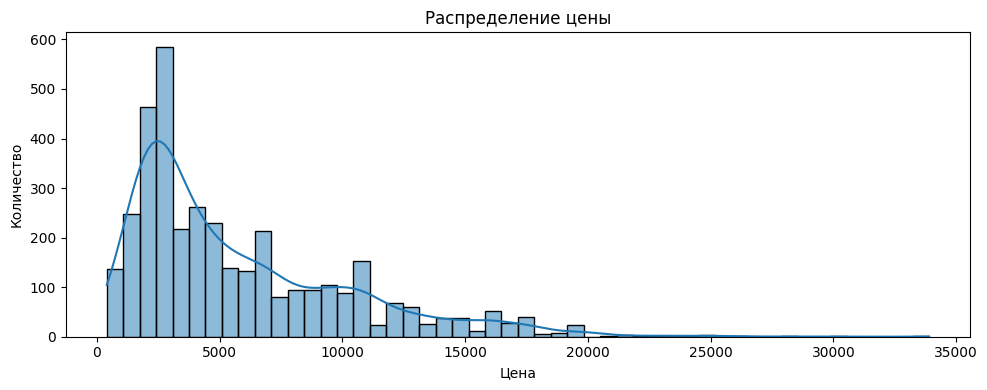

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(df['Price'], bins=50, kde=True, ax=ax)
ax.set_title('Распределение цены')
ax.set_xlabel('Цена')
ax.set_ylabel('Количество')
plt.tight_layout()
plt.show()

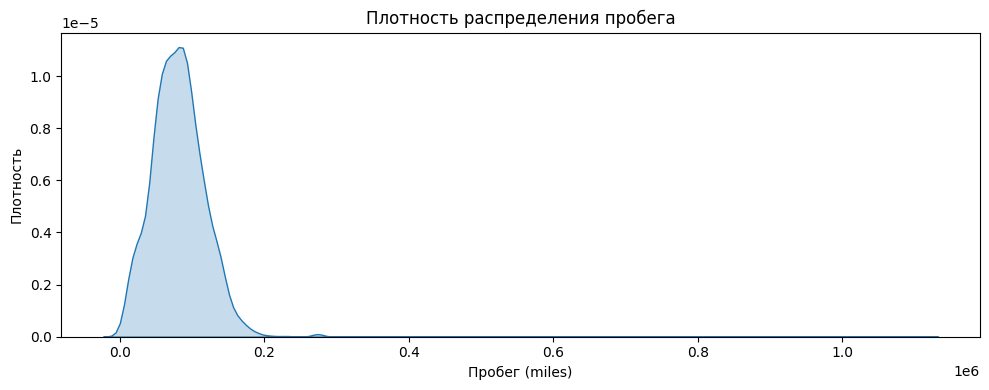

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.kdeplot(df['Mileage(miles)'].dropna(), fill=True, ax=ax)
ax.set_title('Плотность распределения пробега')
ax.set_xlabel('Пробег (miles)')
ax.set_ylabel('Плотность')
plt.tight_layout()
plt.show()

### Категориальные признаки

In [13]:
for col in ['Fuel type', 'Body type', 'Gearbox', 'Service history']:
    freq = df[col].value_counts()
    print(f"--- {col} (мода: {freq.index[0]}) ---")
    print(freq)
    print()

--- Fuel type (мода: Petrol) ---
Fuel type
Petrol                   2361
Diesel                   1218
Petrol Hybrid              47
Electric                   31
Petrol Plug-in Hybrid      27
Diesel Hybrid               1
Name: count, dtype: int64

--- Body type (мода: Hatchback) ---
Body type
Hatchback      2279
SUV             460
Saloon          368
Estate          171
MPV             153
Coupe           139
Convertible     109
Pickup            3
Combi Van         2
Minibus           1
Name: count, dtype: int64

--- Gearbox (мода: Manual) ---
Gearbox
Manual       2868
Automatic     817
Name: count, dtype: int64

--- Service history (мода: Unknown) ---
Service history
Unknown    3145
Full        540
Name: count, dtype: int64



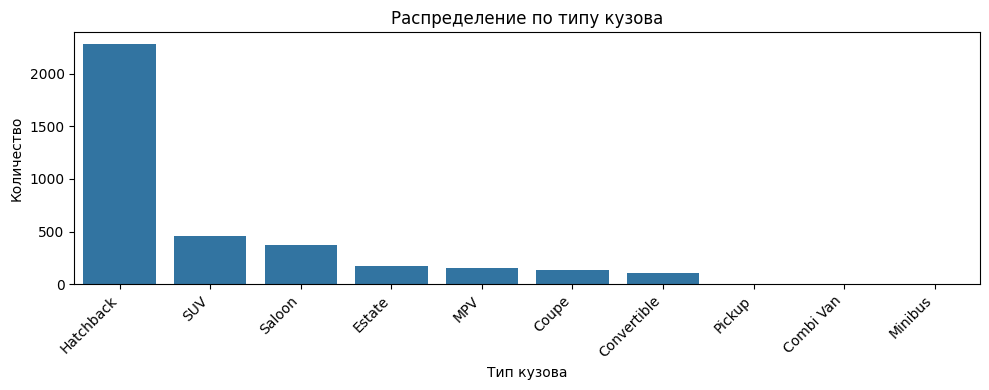

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.countplot(data=df, x='Body type', order=df['Body type'].value_counts().index, ax=ax)
ax.set_title('Распределение по типу кузова')
ax.set_xlabel('Тип кузова')
ax.set_ylabel('Количество')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4. Выявление аномалий

In [15]:
# IQR outlier stats
outlier_features = ['Price', 'Mileage(miles)', 'Registration_Year', 'Previous Owners', 'Engine_L']
for col in outlier_features:
    data = df[col].dropna()
    q1, q3 = data.quantile(0.25), data.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    n = ((data < lo) | (data > hi)).sum()
    print(f"{col}: {n} выбросов ({n/len(data)*100:.1f}%), границы [{lo:.1f}, {hi:.1f}]")

Price: 124 выбросов (3.4%), границы [-5767.5, 16252.5]
Mileage(miles): 34 выбросов (0.9%), границы [-12040.0, 172024.0]
Registration_Year: 23 выбросов (0.6%), границы [1997.5, 2025.5]
Previous Owners: 324 выбросов (8.8%), границы [0.5, 4.5]
Engine_L: 120 выбросов (3.3%), границы [0.4, 2.8]


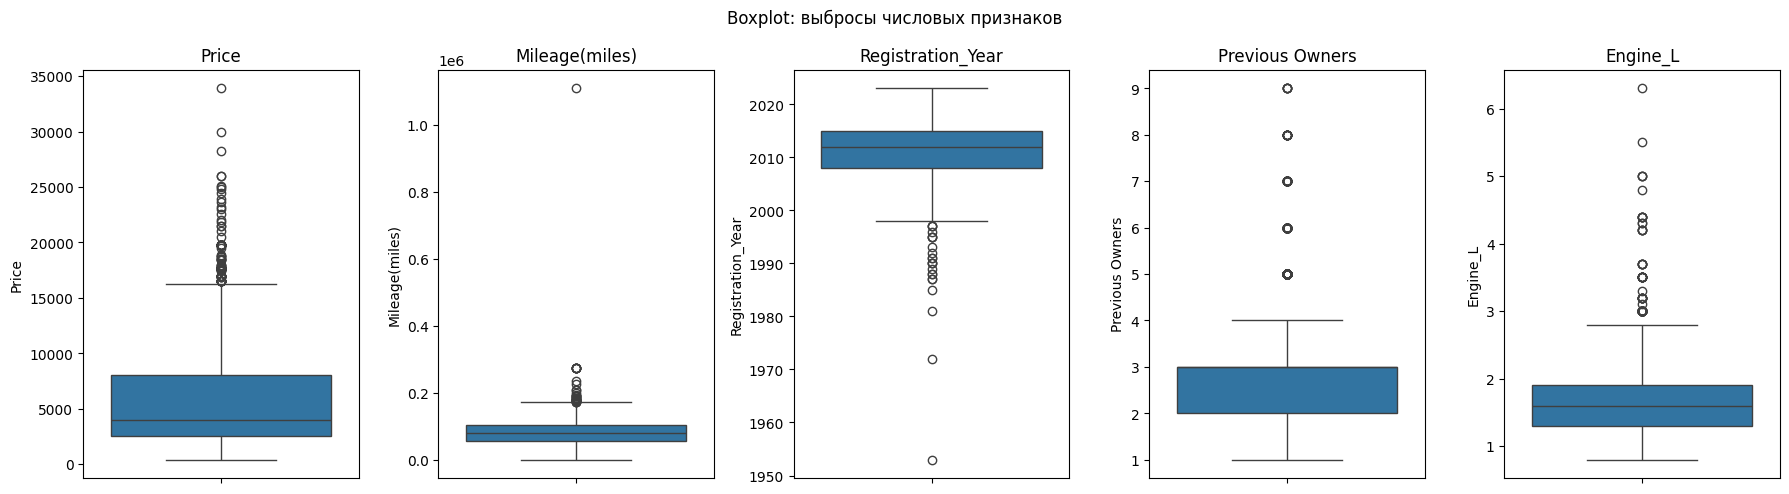

In [16]:
# boxplot
fig, axes = plt.subplots(1, 5, figsize=(18, 5))
for i, col in enumerate(outlier_features):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(col)
plt.suptitle('Boxplot: выбросы числовых признаков')
plt.tight_layout()
plt.show()

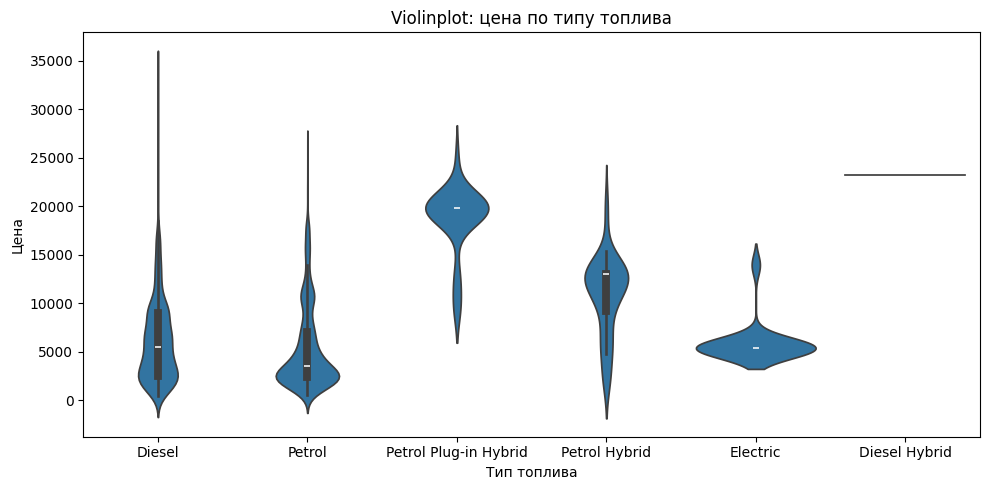

In [17]:
# violinplot for price by fuel type
fig, ax = plt.subplots(figsize=(10, 5))
sns.violinplot(data=df, x='Fuel type', y='Price', ax=ax)
ax.set_title('Violinplot: цена по типу топлива')
ax.set_xlabel('Тип топлива')
ax.set_ylabel('Цена')
plt.tight_layout()
plt.show()

Наибольшее число выбросов в Price и Mileage. В Price сильная правосторонняя асимметрия, есть автомобили со значительно завышенной стоимостью. Previous Owners содержит записи с 7+ владельцами.

## 5. Визуализация с seaborn

### 5.1 countplot - категориальный признак с >=20 категориями (title)

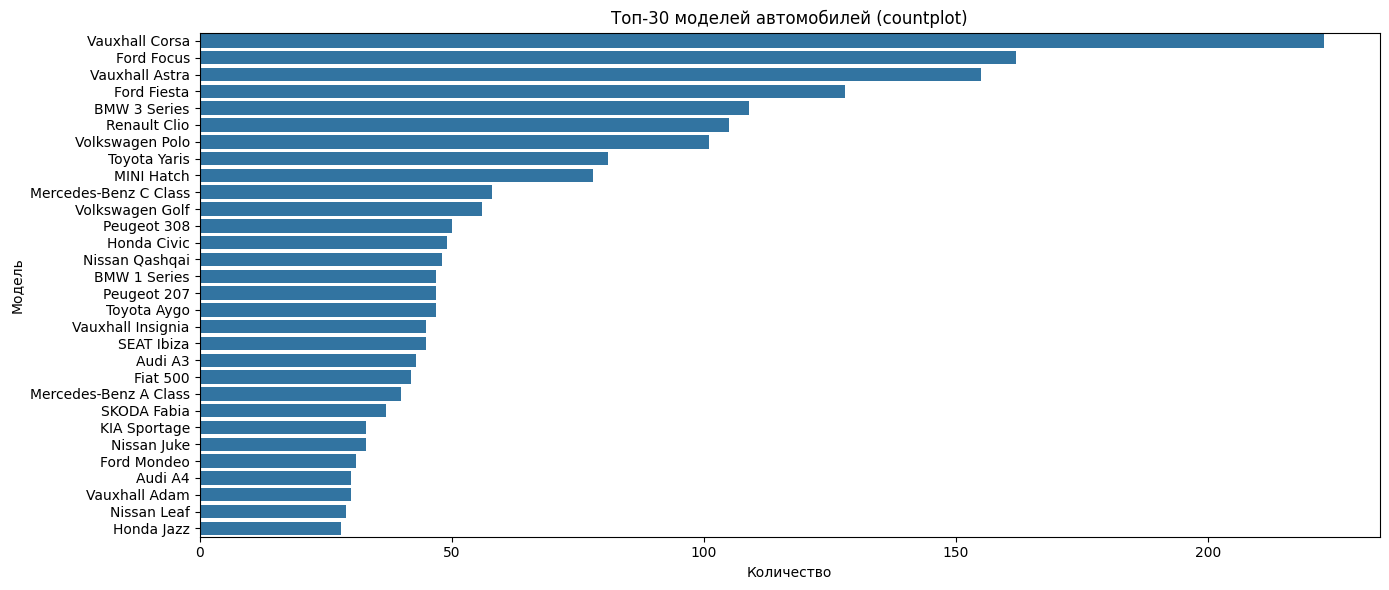

In [18]:
top_models = df['title'].value_counts().head(30)
fig, ax = plt.subplots(figsize=(14, 6))
sns.countplot(data=df[df['title'].isin(top_models.index)], y='title',
              order=top_models.index, ax=ax)
ax.set_title('Топ-30 моделей автомобилей (countplot)')
ax.set_xlabel('Количество')
ax.set_ylabel('Модель')
plt.tight_layout()
plt.show()

Больше всего объявлений по Vauxhall Corsa и Ford Focus

### 5.2 histplot - распределение числового признака

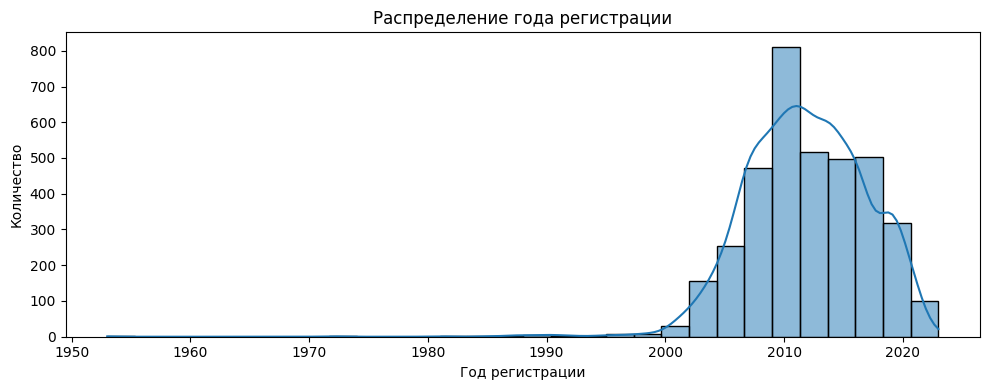

In [19]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(df['Registration_Year'], bins=30, kde=True, ax=ax)
ax.set_title('Распределение года регистрации')
ax.set_xlabel('Год регистрации')
ax.set_ylabel('Количество')
plt.tight_layout()
plt.show()

Большинство автомобилей зарегистрированы в 2010 году. Мало совсем старых и совсем новых.

### 5.3 scatterplot по цене/пробег

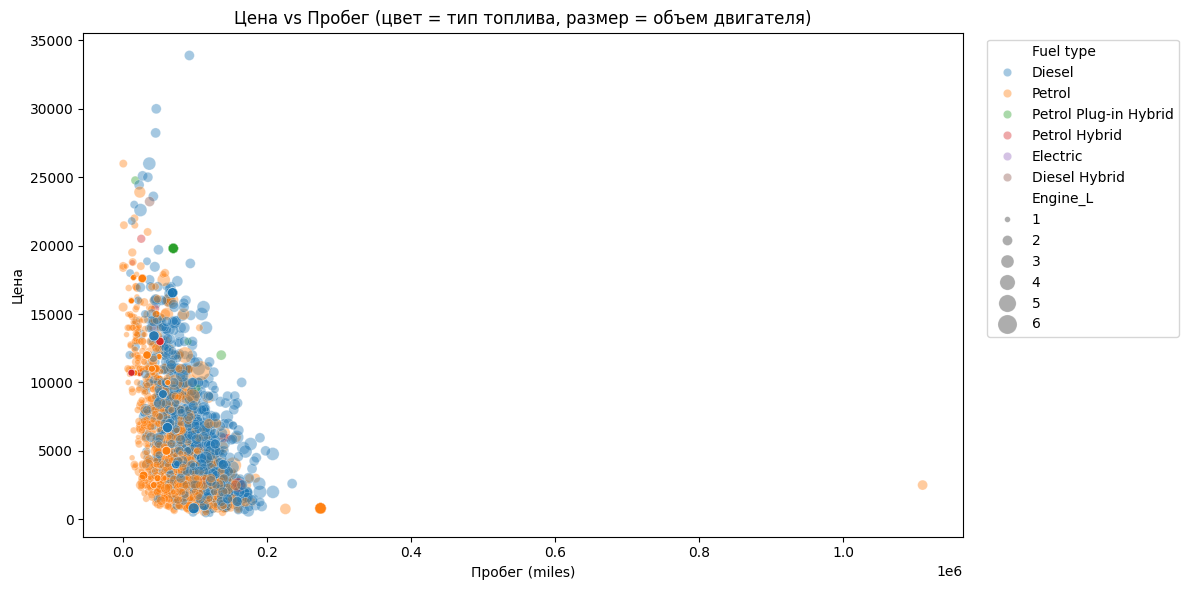

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(data=df, x='Mileage(miles)', y='Price',
                hue='Fuel type', size='Engine_L',
                sizes=(10, 200), alpha=0.4, ax=ax)
ax.set_title('Цена vs Пробег (цвет = тип топлива, размер = объем двигателя)')
ax.set_xlabel('Пробег (miles)')
ax.set_ylabel('Цена')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

С ростом пробега цена падает. Гибриды сконцентрированы в зоне малого пробега и высокой цены. Большие двигатели встречаются в разных ценовых сегментах.

### 5.4 boxplot - выбросы по типу кузова

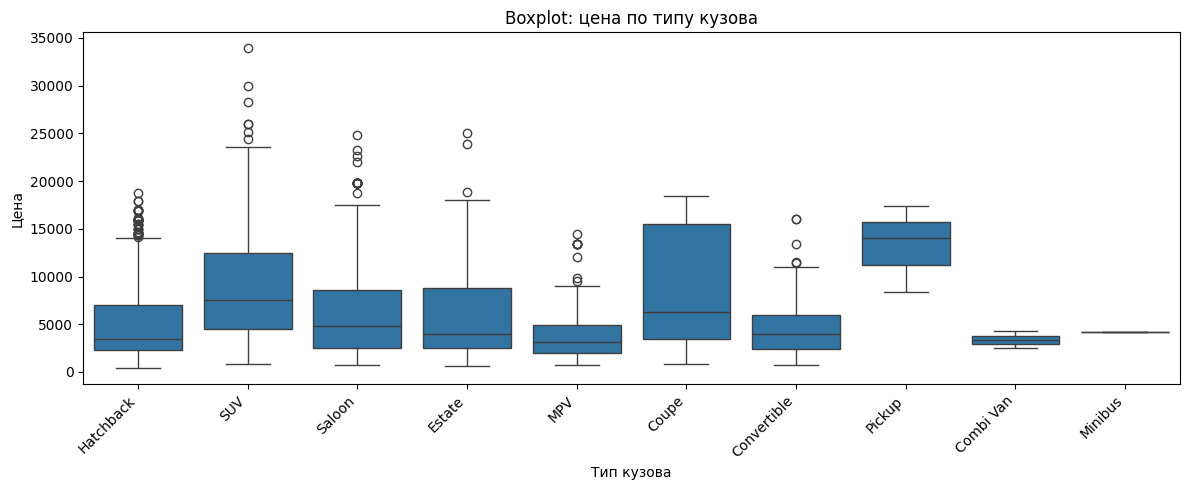

In [21]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=df, x='Body type', y='Price',
            order=df['Body type'].value_counts().index, ax=ax)
ax.set_title('Boxplot: цена по типу кузова')
ax.set_xlabel('Тип кузова')
ax.set_ylabel('Цена')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Pickup имеет наибольший разброс цен. Hatchback - самый дешевый в среднем. Во многих типах видны выбросы вверх

### 5.6 Корреляционная матрица (heatmap)

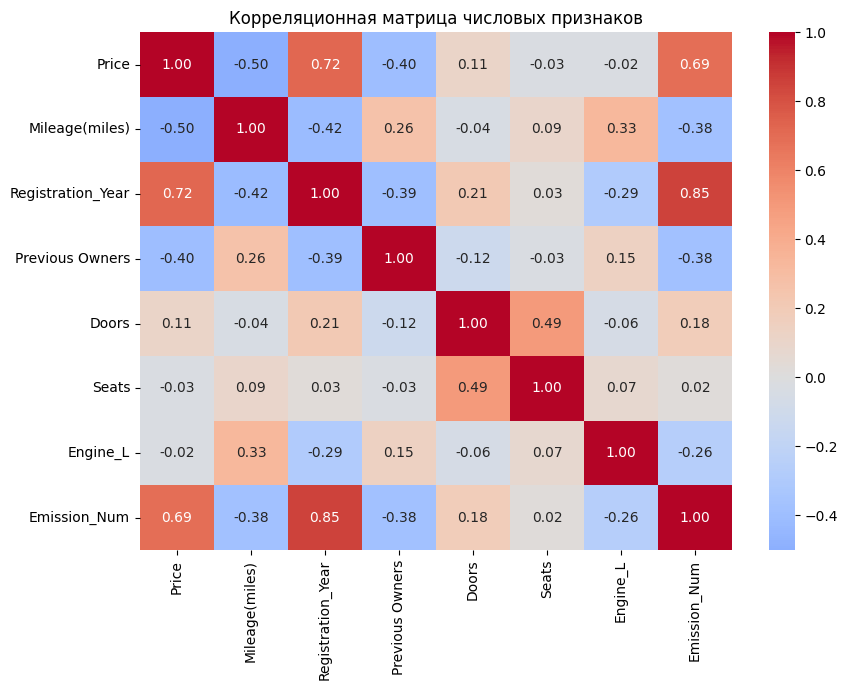

In [23]:
corr = df[num_features].corr()
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax)
ax.set_title('Корреляционная матрица числовых признаков')
plt.tight_layout()
plt.show()

Наибольшая положительная корреляция: Registration_Year и Price (новые дороже). Наибольшая отрицательная: Previous Owners и Price

## 6. Интерпретация и выводы

### Наиболее информативные признаки

- `Mileage` - ключевой фактор: чем больше пробег, тем ниже цена
- `Registration_Year` - второй по важности: новые автомобили дороже
- `Fuel type` - гибриды заметно дороже
- `Gearbox` - автомат дороже механики

### Пропуски и аномалии

- `Service history` - более 60% пропусков, заполнен как `Unknown`
- `Previous Owners` - около 20% пропусков, заполнены медианой
- `Price` - значительные выбросы вправо (дорогие автомобили)
- `Mileage` - есть автомобили с экстремальным пробегом

### Распределение категорий в title

Распределение крайне неравномерное. Несколько моделей (Ford Fiesta, Vauxhall Corsa, Ford Focus) доминируют с десятками объявлений, тогда как большинство моделей представлены единичными записями